In [ ]:
import torch
import torchvision
from torch import nn, optim, no_grad


# Implémentez le même modele que le précédent en torch

- vous pouvez utiliser nn.Sequential(...) de manière similaire à keras
- nn.Flatten()
- nn.Softmax()
- Dense n'existe pas, il faut l'obtenir comme combinaison de Linear (perceptron) et une fonction d'activation de votre choix (RelU)

In [2]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)
model


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

- attention: model.train n'entraine pas le modele, mais permet juste de mettre ses poids comme "entrainables"

In [3]:
model.train()


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

## Télécharger et préparer le jeu de donnée fashion mnist

In [4]:
# Créer un générateur de batch
from tensorflow.keras.datasets import fashion_mnist
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
(train_img, train_lbl), (val_img, val_lbl) = fashion_mnist.load_data()


- pytorch ne possède pas de primitives aussi haut niveau que keras pour l'entrainement.
- les reseaux de neurones sont entrainés par "batchs", un petit nombre de données suffisamment petit pour tenir en mémoire, mais suffisamment grand pour que des indicateurs statistiques (par exemple la moyenne, utilisée pour obtenir la loss) fonctionne dessus. Keras nous cache la création de batch, mais pour Pytorch il faut l'écrire !
- créez donc une fonction prenant en entrée la taille des batchs désirées, et donnant en sortie les batchs du jeu d'entrainement et leurs labels correspondants
- astuce : les générateurs en pythons sont particulierement adaptés à cela !

In [5]:
def batch_generator(data, label, batch_size):
    current_idx = 0
    size = len(label)
    while(current_idx + batch_size < size):
        yield(data[current_idx:current_idx+batch_size], label[current_idx:current_idx+batch_size])
        current_idx += batch_size


Le générateur ci-dessus est très simple, comment pourrait-on l'améliorer  ?
- mélanger le jeu de donnée avant de le fournir
- mieux gérer les derniers éléments (buffer circulaire par exemple)

- on crée l'optimizer et la fonction de loss, comme pour keras :

In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.NLLLoss()


- effectuer l'entrainement. A chaque epoque, l'ensemble du jeu de donnée doit être présenter, batch par batch, et le modele est entrainé par descente du gradient sur ce batch

In [7]:
epochs = 10
batch_size = 1000
for epoch in range(epochs):
    print("Epoch ", epoch)
    nb_batch = 0
    for batch, label in batch_generator(train_img, train_lbl, batch_size):
        # il est necessaire de convertir nos données numpy en tensor torch au bon format
        batch = torch.from_numpy(batch).float()
        label = torch.from_numpy(label).long()

        # remet à zero les gradients
        optimizer.zero_grad()

        # obtient les predictions sur le batch en cours
        batch_preds = model(batch)
        # calcule la loss en fonction des predictions et des labels pour le batch
        batch_loss = loss_function(batch_preds, label)

        # effectue l'entrainement en calculant les gradients, puis modifiant les poids suivant la politique de l'optimizer.
        batch_loss.backward()
        optimizer.step()


Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9


- Pytorch cache moins le fonctionnement précis des réseaux de neurones que Keras
- Cela offre davantage de souplesse et de fonctionalité
- On peut faire pareil en Keras/Tensorflow, et on en a parfois besoin ! (par exemple lorsque l'on a besoin de calculer plus qu'une sortie, par exemple la valeur de couches intermediaires pour de la visualisation/explication)
- Il nécessite un peu plus de code
- A retenir : il faut toujours penser à caster les entrées en tenseurs, et caster les sorties en numpy si besoin.
    - ce formalisme est justifié car avoir acces au tensor nous permer par exemple de choisir de le mettre sur cpu ou sur gpu, et ainsi offre une manière simple de faire tourner nos reseaux de neurones sur cpu ou gpu
    - gpu_tensor = notre_tensor.to(torch.device("cuda:0"))
    - cela permet aussi dynamiquement de choisir sur quel gpus ou cpu faire nos calculs si on en a plusieurs !

## Evaluation des résultats

- vous pouvez utiliser le code du tp keras
- il vous faudra convertir la sortie du réseau (tenseur) en numpy
    - val_pred.detach().numpy()

In [8]:
val_data = torch.from_numpy(val_img).float()
val_pred = model(val_data)
numpy_preds = val_pred.detach().numpy()


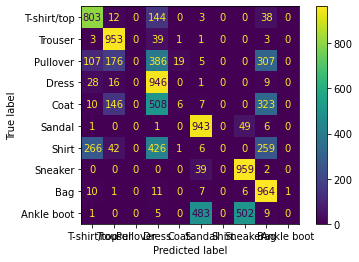

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
pred = np.argmax(numpy_preds, axis=-1)


cm = confusion_matrix(val_lbl, pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot()


## Next steps : améliorez le model

- en augmentant sa capacité (nombre de couche, nombre de neurones par couche)
- en jouant avec son temps et paramètres d'entrainement (epochs, taille de batch, taux d'apprentissage, ...)
- son architecture (loss, fonction d'activation, ...)
- en évitant le surapprentissage, par exemple en testant regulierement les performances de validation, et en s'arrétant si les performances de validations se mettent à diminuer